In [25]:
from translation import FJSSPInstancesTranslator, SequenceGAEncoder
from model import ProductionEnvironment, Order
benchmark_base_path = r'C:\Users\huda\Documents\GitHub\scheduling_model\code\external_test_data\FJSSPinstances\\'

In [26]:
def read_benchmark_file(source, instance):
    if source.startswith('0'):
        target_file = f'Behnke{instance}.fjs'
    elif source.startswith('1'):
        target_file = f'BrandimarteMk{instance}.fjs'
    elif source.startswith('2a'):
        target_file = f'HurinkSdata{instance}.fjs'
    elif source.startswith('2b'):
        target_file = f'HurinkEdata{instance}.fjs'
    elif source.startswith('2c'):
        target_file = f'HurinkRdata{instance}.fjs'
    elif source.startswith('2d'):
        target_file = f'HurinkVdata{instance}.fjs'
    elif source.startswith('3'):
        target_file = f'DPpaulli{instance}.fjs'
    elif source.startswith('4'):
        target_file = f'ChambersBarnes{instance}.fjs'
    elif source.startswith('5'):
        target_file = f'Kacem{instance}.fjs'
    elif source.startswith('6'):
        target_file = f'Fattahi{instance}.fjs'
    path = benchmark_base_path + f'{source}\\{target_file}'
    return open(path, 'r').readlines()

In [27]:
def generate_one_order_per_recipe(production_environment : ProductionEnvironment) -> list[Order]:
    orders : list[Order] = []
    for i in range(len(production_environment.resources.values())): # should be the same amount as recipes for now
        orders.append(Order(delivery_time=1000, latest_acceptable_time=1000, resources=[(production_environment.get_resource(i), 1)], penalty=100.0, tardiness_fee=50.0, divisible=False, profit=500.0))
    return orders

In [28]:
sources = ['0_BehnkeGeiger', '1_Brandimarte', '2a_Hurink_sdata', '2b_Hurink_edata', '2c_Hurink_rdata', '2d_Hurink_vdata', '3_DPpaulli', '4_ChambersBarnes', '5_Kacem', '6_Fattahi']
data = []
for source in sources:
    n = 0
    if source.startswith('0'):
        n = 60
    elif source.startswith('1'):
        n = 15
    elif source.startswith('2'):
        n = 66
    elif source.startswith('3'):
        n = 18
    elif source.startswith('4'):
        n = 21
    elif source.startswith('5'):
        n = 4
    else:
        n = 20
    for i in range(1, n+1):
        line = []
        benchmark_file = read_benchmark_file(source, i)
        benchmark_system = benchmark_file[0].split(' ')
        line.append(source)
        line.append(i)
        line.append(int(benchmark_system[1])) # n_machines
        line.append(int(benchmark_system[0])) # n_jobs
        line.append(float(benchmark_system[2])) #average_machines_per_operation
        jobs = benchmark_file[1:]
        line.append(sum([int(x.split(' ')[0]) for x in jobs])) # n_operations
        line.append(line[5] / line[3])# = line['n_operations'] / line['n_jobs'] #average_operations_per_job
        line.append(line[4] / line[2])#['beta_flexibility'] = line['average_workstations_per_operation']/line['n_machines']
        line.append(line[5] + line[6] * line[4]) # approx. max. dissimilarity
        #line['approximate_max_dissimilarity'] = line['n_operations'] + line['average_operations_per_job'] * line['average_workstations_per_operation']
        #line['limit'] = limit
        production_environment = FJSSPInstancesTranslator().translate(source, i)
        orders = generate_one_order_per_recipe(production_environment)
        production_environment.orders = orders
        workstations_per_operation, base_durations, job_operations = SequenceGAEncoder().encode(production_environment, orders)
        unique_durations = []
        overall_amount_durations = []
        count_per_operation = []
        for duration in base_durations:
            for_duration = []
            for d in duration:
                if d not in for_duration and d > 0:
                    for_duration.append(d)
                if d not in unique_durations and d > 0:
                    unique_durations.append(d)
            count_per_operation.append(len(for_duration))
            overall_amount_durations.extend([x for x in duration if x > 0])
        overall_amount_durations = len(overall_amount_durations)
        line.append(len(unique_durations)/overall_amount_durations) # duration variety 
        line.append(unique_durations)
        line.append(sum(count_per_operation)/line[5])
        data.append(line)

In [29]:
import pandas as pd
df = pd.DataFrame(data)

In [30]:
df.columns = ['source', 'instance', 'n_machines', 'n_jobs', 'average_machines_per_operation', 'n_operations', 'average_operations_per_job', 'flexibility', 'approx.max.dissimilarity', 'duration_variety', 'unique_durations', 'average_unique_durations_per_operation']

In [31]:
df

,source,instance,n_machines,n_jobs,average_machines_per_operation,n_operations,average_operations_per_job,flexibility,approx.max.dissimilarity,duration_variety,unique_durations,average_unique_durations_per_operation
0,0_BehnkeGeiger,1,20,10,6.08,50,5.0,0.304000,80.4,0.069079,"[26, 24, 13, 28, 25, 12, 30, 11, 22, 20, 16, 1...",5.160000
1,0_BehnkeGeiger,2,20,10,6.72,50,5.0,0.336000,83.6,0.062500,"[27, 25, 14, 13, 22, 11, 23, 19, 17, 16, 12, 2...",5.640000
2,0_BehnkeGeiger,3,20,10,6.24,50,5.0,0.312000,81.2,0.067308,"[25, 20, 11, 13, 23, 27, 30, 22, 26, 17, 19, 1...",5.460000
3,0_BehnkeGeiger,4,20,10,6.64,50,5.0,0.332000,83.2,0.063253,"[28, 14, 23, 19, 16, 11, 21, 17, 20, 22, 18, 2...",5.540000
4,0_BehnkeGeiger,5,20,10,6.16,50,5.0,0.308000,80.8,0.068182,"[18, 12, 15, 29, 11, 30, 10, 24, 13, 22, 17, 2...",5.140000
...,...,...,...,...,...,...,...,...,...,...,...,...
397,6_Fattahi,16,7,8,2.60,24,3.0,0.371429,31.8,0.677419,"[247, 223, 100, 130, 140, 123, 150, 160, 200, ...",2.583333
398,6_Fattahi,17,7,8,2.40,32,4.0,0.342857,41.6,0.589744,"[247, 223, 100, 130, 140, 123, 150, 160, 200, ...",2.406250
399,6_Fattahi,18,8,9,2.40,36,4.0,0.300000,45.6,0.546512,"[247, 123, 100, 130, 140, 150, 160, 200, 210, ...",2.333333
400,6_Fattahi,19,8,11,2.30,44,4.0,0.287500,53.2,0.456311,"[247, 123, 100, 130, 140, 150, 160, 200, 210, ...",2.250000


In [32]:
df.to_csv(r'C:\Users\huda\Documents\GitHub\scheduling_model\code\reworked_data_model\results\benchmark_descriptions.csv')

In [33]:
import seaborn as sns

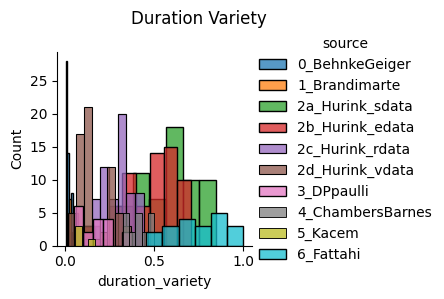

In [34]:
fg = sns.FacetGrid(data=df, hue='source', aspect=1)
fg.fig.suptitle("Duration Variety")
fg.map_dataframe(sns.histplot, x='duration_variety').add_legend()

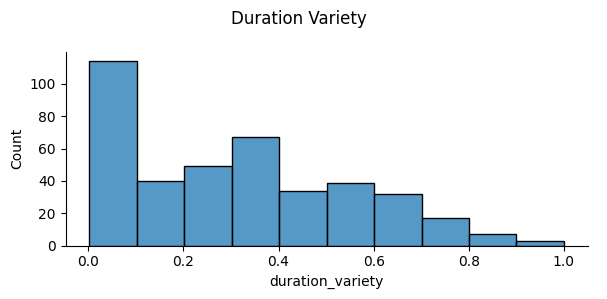

In [35]:
fg = sns.FacetGrid(data=df, aspect=2)
fg.fig.suptitle("Duration Variety")
fg.map_dataframe(sns.histplot, x='duration_variety').add_legend()

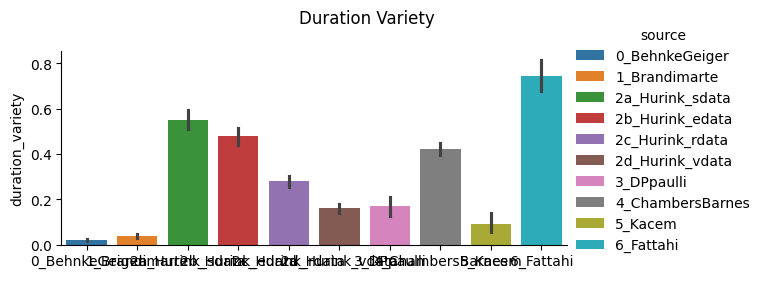

In [36]:
fg = sns.FacetGrid(data=df, hue='source', aspect=2)
fg.fig.suptitle("Duration Variety")
fg.map_dataframe(sns.barplot, x='source', y='duration_variety').add_legend().set(xlabel=None)

AttributeError: 'AxesSubplot' object has no attribute 'add_legend'

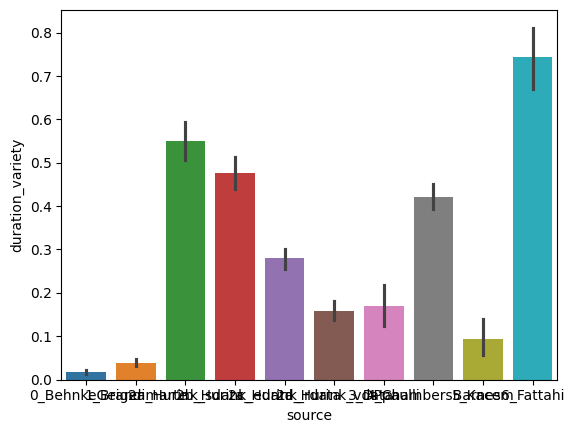

In [37]:
plot = sns.barplot(data=df, x='source', y='duration_variety', hue='source').add_legend()
#plot.add_legend()
plot.set(xlabel=None) #?????

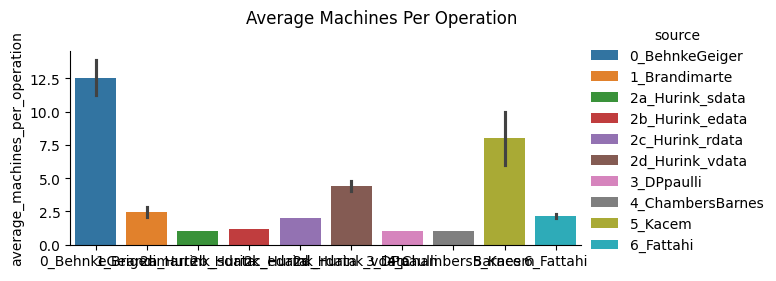

In [45]:
fg = sns.FacetGrid(data=df, hue='source', aspect=2)
fg.fig.suptitle("Average Machines Per Operation")
fg.map_dataframe(sns.barplot, x='source', y='average_machines_per_operation').add_legend().set(xlabel=None)

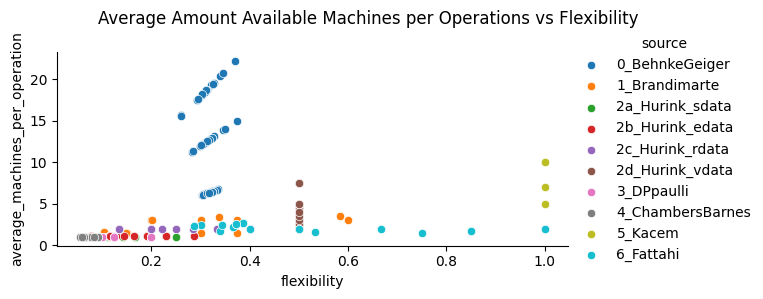

In [39]:
fg = sns.FacetGrid(data=df, hue='source', aspect=2)
fg.fig.suptitle("Average Amount Available Machines per Operations vs Flexibility")
fg.map_dataframe(sns.scatterplot, x='flexibility', y='average_machines_per_operation').add_legend()#.set(xlabel=None)

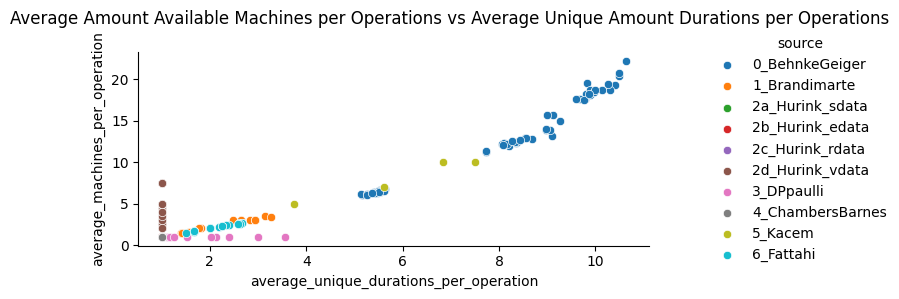

In [43]:
fg = sns.FacetGrid(data=df, hue='source', aspect=2)
fg.fig.suptitle("Average Amount Available Machines per Operations vs Average Unique Amount Durations per Operations")
fg.map_dataframe(sns.scatterplot, x='average_unique_durations_per_operation', y='average_machines_per_operation').add_legend()#.set(xlabel=None)

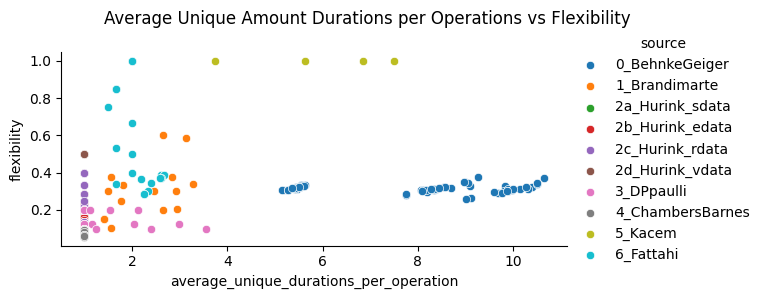

In [44]:
fg = sns.FacetGrid(data=df, hue='source', aspect=2)
fg.fig.suptitle("Average Unique Amount Durations per Operations vs Flexibility")
fg.map_dataframe(sns.scatterplot, x='average_unique_durations_per_operation', y='flexibility').add_legend()#.set(xlabel=None)